In [21]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint 
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

In [ ]:
# data downloading and reading
"""
XLK ETF top 25 components (Technology): 
['NVDA', 'AAPL', 'MSFT', 'AVGO', 'PLTR', 'AMD', 'CSCO', 'ORCL', 'IBM', 'MU',
               'CRM', 'AMAT', 'LRCX', 'QCOM', 'INTU', 'APH', 'NOW', 'INTC', 'APP', 'ACN',
               'KLAC', 'TXN', 'ADBE', 'ANET', 'ADI']

XLRE ETF top 30 components (Real Estate):
['WELL', 'PLD', 'AMT', 'EQIX', 'SPG', 'CBRE', 'O', 'PSA', 'DLR', 'CCI',
               'VTR', 'VICI', 'CSGP', 'EXR', 'AVB', 'IRM', 'EQR', 'SBAC', 'ESS', 'WY',
               'MAA', 'INVH', 'KIM', 'DOC', 'REG', 'CPT', 'HST', 'UDR', 'BXP', 'ARE']

"""
# Symbols to download
symbol_list = ['WELL', 'PLD', 'AMT', 'EQIX', 'SPG', 'CBRE', 'O', 'PSA', 'DLR', 'CCI',
               'VTR', 'VICI', 'CSGP', 'EXR', 'AVB', 'IRM', 'EQR', 'SBAC', 'ESS', 'WY',
               'MAA', 'INVH', 'KIM', 'DOC', 'REG', 'CPT', 'HST', 'UDR', 'BXP', 'ARE']

# # set the dates range
# start_date = '2020-01-01'
# end_date = dt.datetime.now().strftime('%Y-%m-%d')

# # download data
# # data = yf.download(symbol_list, period="max", group_by='ticker', auto_adjust=True)
# data = yf.download(symbol_list, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# # download data to csv
# data.to_csv(f"{'_'.join(symbol_list)}_D_data.csv")

# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv(f"{'_'.join(symbol_list)}_D_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

data = df.copy()

# Show the result
data.head()

[*********************100%***********************]  30 of 30 completed


Ticker            CPT                                                    ESS  \
Price            Open       High        Low      Close    Volume        Open   
Date                                                                           
2020-01-02  87.804373  87.804373  86.190716  86.495331  585600.0  246.653801   
2020-01-03  86.231910  87.425692  86.050784  87.186935  473800.0  242.516039   
2020-01-06  87.310420  87.870261  86.758808  87.598572  835100.0  245.339741   
2020-01-07  87.203394  87.359822  86.380099  86.520058  556000.0  243.454566   
2020-01-08  86.487112  86.981088  86.166028  86.701164  614200.0  242.246663   

Ticker                                                    ...          O  \
Price             High         Low       Close    Volume  ...       Open   
Date                                                      ...              
2020-01-02  247.535192  241.455141  243.430145  412400.0  ...  53.371065   
2020-01-03  246.131412  241.977401  245.813141  400700.0  ...  52.171372   
2020-01-06  246.417016  243.813615  244.833755  369200.0  ...  53.226522   
2020-01-07  244.580805  240.377830  241.838654  327200.0  ...  53.985337   
2020-01-08  244.499141  241.479540  243.234177  450500.0  ...  53.681830   

Ticker                                                         WY             \
Price            High        Low      Close     Volume       Open       High   
Date                                                                           
2020-01-02  53.479468  51.983489  52.380970  2061523.0  24.256056  24.280144   
2020-01-03  53.407180  52.113555  53.327682  1826227.0  23.421036  23.750231   
2020-01-06  53.811903  52.988030  53.595097  1324056.0  23.525407  23.702049   
2020-01-07  53.985337  53.002468  53.609535  1610436.0  23.525413  23.677968   
2020-01-08  53.942002  53.421659  53.855278  1912812.0  23.380888  23.621762   

Ticker                                       
Price             Low      Close     Volume  
Date                                         
2020-01-02  23.509346  23.597666  4973500.0  
2020-01-03  23.404977  23.637823  3111000.0  
2020-01-06  23.445116  23.589640  2178600.0  
2020-01-07  23.380890  23.437094  2426200.0  
2020-01-08  23.356800  23.525412  2299800.0  

[5 rows x 150 columns]

In [23]:
# Print data length and date range before dropping NaNs
print(f"Initial data shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")

# Remove rows where all values are NaN
data = data.dropna(how='all')

# For pairs trading, we typically only need Close prices
# Extract Close prices for both tickers
close_prices = data.xs('Close', level=1, axis=1)

# Clean ticker names if needed (remove any suffixes, for forex scenario)
close_prices.columns = close_prices.columns.str.replace('=X', '', regex=False)

# Drop any remaining NaN values
close_prices = close_prices.dropna()

# Print data length and date range after dropping NaNs
print(f"Data shape after dropping all-NaN rows: {close_prices.shape}")
print(f"Date range: {close_prices.index.min()} to {close_prices.index.max()}")

print("Cleaned close prices data:")
print(close_prices.head())
print(f"\nData shape: {close_prices.shape}")
print(f"Date range: {close_prices.index.min()} to {close_prices.index.max()}")

# Use close_prices for the pairs trading analysis
data = close_prices

Initial data shape: (1486, 150)
Date range: 2020-01-02 to 2025-11-28
Data shape after dropping all-NaN rows: (1486, 30)
Date range: 2020-01-02 to 2025-11-28
Cleaned close prices data:
Ticker            CPT         ESS        REG        EQR         CCI  \
Date                                                                  
2020-01-02  86.495331  243.430145  48.440369  63.966492  110.266434   
2020-01-03  87.186935  245.813141  49.013668  64.792435  110.873505   
2020-01-06  87.598572  244.833755  49.139320  64.976868  109.939568   
2020-01-07  86.520058  241.838654  48.440369  64.014618  108.079460   
2020-01-08  86.701164  243.234177  48.833027  64.150925  108.530869   

Ticker            EXR        DLR         AMT        HST         AVB  ...  \
Date                                                                 ...   
2020-01-02  84.508507  96.832558  195.522339  15.089975  169.673325  ...   
2020-01-03  85.952873  98.424553  195.616455  14.932704  171.302567  ...   
2020-01-06  85

In [24]:
# # manual filter to keep Date >= '2014-01-01'
# data = data[data.index >= '2014-01-01']

# # manual filter to exclude Date >= '2024-01-01'
# data = data[data.index < '2024-01-01']

In [25]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [26]:
# Time Series Split for Pairs Trading
# For financial time series, we use temporal split instead of random split
# This preserves the time order and avoids look-ahead bias
def temporal_split(data, train_ratio=0.7):
    """
    Split time series data temporally (chronologically)
    
    Parameters:
    data: DataFrame with time series data
    train_ratio: proportion of data to use for training (default 70%)
    
    Returns:
    train_data: DataFrame with training period data
    test_data: DataFrame with testing period data
    split_date: the date where split occurs
    """
    n_train = int(len(data) * train_ratio)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]
    split_date = data.index[n_train-1] if n_train > 0 else data.index[0]
    
    print(f"Total observations: {len(data)}")
    print(f"Training period: {data.index[0]} to {split_date} ({len(train_data)} observations)")
    print(f"Testing period: {data.index[n_train]} to {data.index[-1]} ({len(test_data)} observations)")
    print(f"Train ratio: {len(train_data)/len(data):.1%}")
    
    return train_data, test_data, split_date

# Split the data temporally
train_data, test_data, split_date = temporal_split(data, train_ratio=0.7)

Total observations: 1486
Training period: 2020-01-02 to 2024-02-20 (1040 observations)
Testing period: 2024-02-21 to 2025-11-28 (446 observations)
Train ratio: 70.0%


In [27]:
# Step 1: Find cointegrated pairs using TRAINING data only
# This prevents look-ahead bias in the strategy
scores_train, pvalues_train, pairs_train = find_cointegrated_pairs(train_data)

print("=== TRAINING PERIOD COINTEGRATION ANALYSIS ===")
print(f"Analysis period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Number of observations: {len(train_data)}")

=== TRAINING PERIOD COINTEGRATION ANALYSIS ===
Analysis period: 2020-01-02 to 2024-02-20
Number of observations: 1040


In [28]:
# Step 2: Validate cointegration on TEST data
# Check if pairs found in training period maintain cointegration in test period
scores_test, pvalues_test, pairs_test = find_cointegrated_pairs(test_data)

print("\n=== TESTING PERIOD COINTEGRATION VALIDATION ===")
print(f"Analysis period: {test_data.index[0]} to {test_data.index[-1]}")
print(f"Number of observations: {len(test_data)}")


=== TESTING PERIOD COINTEGRATION VALIDATION ===
Analysis period: 2024-02-21 to 2025-11-28
Number of observations: 446


In [29]:
# Function to validate pairs consistency
def validate_pairs_consistency(pairs_train, pairs_test, pvalues_train, pvalues_test, data_train, data_test):
    """
    Validate if pairs found in training maintain cointegration in testing
    """
    print(f"\nPairs found in training: {len(pairs_train)}")
    print(f"Pairs found in testing: {len(pairs_test)}")

    # print names of pairs found in training
    print("\nPairs found in training period:")
    for pair in pairs_train:
        print(f"- {pair[0]} / {pair[1]}")   

    # print names of pairs found in testing
    print("\nPairs found in testing period:")
    for pair in pairs_test:
        print(f"- {pair[0]} / {pair[1]}")
    
    # Handle case when no training pairs exist
    if len(pairs_train) == 0:
        print("No pairs found in training period - cannot validate consistency")
        print("Consider:")
        print("- Relaxing cointegration threshold (e.g., p < 0.1)")
        print("- Using longer training period")
        print("- Checking data quality")
        
        # Show best pairs from training period anyway
        if len(pvalues_train) > 0:
            symbols = list(data_train.columns)
            n = len(symbols)
            
            best_train_pairs = []
            for i in range(n):
                for j in range(i+1, n):
                    best_train_pairs.append({
                        'pair': f"{symbols[i]}/{symbols[j]}",
                        'train_pvalue': pvalues_train[i, j],
                        'significant': pvalues_train[i, j] < 0.05
                    })
            
            best_train_df = pd.DataFrame(best_train_pairs)
            best_train_df = best_train_df.sort_values('train_pvalue')
            
            print(f"\nBest pairs from training (sorted by p-value):")
            print(best_train_df.head(5))
        
        return [], pd.DataFrame()
    
    # Check which training pairs are also significant in testing
    consistent_pairs = []
    validation_results = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        
        # Find indices for this pair in training data
        train_cols = list(data_train.columns)
        i_train = train_cols.index(symbol1)
        j_train = train_cols.index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i_train > j_train:
            i_train, j_train = j_train, i_train
        
        train_pvalue = pvalues_train[i_train, j_train]
        
        # Find indices for this pair in testing data  
        test_cols = list(data_test.columns)
        i_test = test_cols.index(symbol1)
        j_test = test_cols.index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i_test > j_test:
            i_test, j_test = j_test, i_test
        
        test_pvalue = pvalues_test[i_test, j_test]
        
        # Check if still cointegrated in test period
        is_consistent = test_pvalue < 0.05
        
        validation_results.append({
            'pair': f"{symbol1}/{symbol2}",
            'train_pvalue': train_pvalue,
            'test_pvalue': test_pvalue,
            'consistent': is_consistent,
            'pvalue_change': test_pvalue - train_pvalue
        })
        
        if is_consistent:
            consistent_pairs.append(pair)
    
    # Create validation DataFrame
    validation_df = pd.DataFrame(validation_results)
    if len(validation_df) > 0:
        validation_df = validation_df.sort_values('test_pvalue')
    
    print(f"Consistent pairs (significant in both periods): {len(consistent_pairs)}")
    if len(pairs_train) > 0:
        print(f"Consistency rate: {len(consistent_pairs)/len(pairs_train):.1%}")
    
    return consistent_pairs, validation_df

# Validate pairs consistency
consistent_pairs, validation_df = validate_pairs_consistency(
    pairs_train, pairs_test, pvalues_train, pvalues_test, train_data, test_data
)

if len(validation_df) > 0:
    print(f"\n=== PAIRS VALIDATION RESULTS ===")
    print(validation_df)
else:
    print(f"\n=== NO VALIDATION POSSIBLE ===")
    print("No cointegrated pairs found in training period")

if len(consistent_pairs) > 0:
    print("\nConsistent pairs across training and testing periods:")
    for pair in consistent_pairs:
        print(f"- {pair[0]} / {pair[1]}")


Pairs found in training: 29
Pairs found in testing: 15

Pairs found in training period:
- CPT / UDR
- REG / PSA
- EQR / UDR
- EQR / MAA
- CCI / DOC
- EXR / O
- AMT / DOC
- AMT / BXP
- AMT / ARE
- HST / PSA
- HST / IRM
- HST / WELL
- HST / SPG
- HST / KIM
- HST / WY
- PSA / KIM
- PSA / O
- SBAC / ARE
- EQIX / WELL
- DOC / ARE
- VTR / PLD
- VTR / MAA
- VTR / CBRE
- VTR / INVH
- VTR / WY
- PLD / SPG
- PLD / CBRE
- PLD / INVH
- MAA / O

Pairs found in testing period:
- CPT / ESS
- ESS / HST
- ESS / PSA
- ESS / EQIX
- ESS / CSGP
- EQR / EXR
- EQR / AVB
- EQR / UDR
- CCI / AMT
- HST / MAA
- PSA / IRM
- IRM / BXP
- IRM / KIM
- SPG / CBRE
- CBRE / INVH
Consistent pairs (significant in both periods): 1
Consistency rate: 3.4%

=== PAIRS VALIDATION RESULTS ===
         pair  train_pvalue  test_pvalue  consistent  pvalue_change
2     EQR/UDR      0.038108     0.021370        True      -0.016738
4     CCI/DOC      0.022422     0.151504       False       0.129081
3     EQR/MAA      0.040314     0.2

In [30]:
# # Alternative Analysis with Relaxed Threshold (p < 0.1)
# print("\n" + "="*50)
# print("ALTERNATIVE ANALYSIS WITH RELAXED THRESHOLD")
# print("="*50)

# def find_cointegrated_pairs_relaxed(data, threshold=0.1):
#     """
#     Same as find_cointegrated_pairs but with adjustable threshold
#     """
#     n = data.shape[1]
#     score_matrix = np.zeros((n, n))
#     pvalue_matrix = np.ones((n, n))
#     keys = data.keys()
#     pairs = []
#     for i in range(n):
#         for j in range(i+1, n):
#             S1 = data[keys[i]]
#             S2 = data[keys[j]]
#             result = coint(S1, S2)
#             score = result[0]
#             pvalue = result[1]
#             score_matrix[i, j] = score
#             pvalue_matrix[i, j] = pvalue
#             if pvalue < threshold:
#                 pairs.append((keys[i], keys[j]))
#     return score_matrix, pvalue_matrix, pairs

# # Try with p < 0.1 threshold
# scores_train_relaxed, pvalues_train_relaxed, pairs_train_relaxed = find_cointegrated_pairs_relaxed(train_data, 0.1)
# scores_test_relaxed, pvalues_test_relaxed, pairs_test_relaxed = find_cointegrated_pairs_relaxed(test_data, 0.1)

# print(f"Training pairs (p < 0.1): {len(pairs_train_relaxed)}")
# print(f"Testing pairs (p < 0.1): {len(pairs_test_relaxed)}")

# # Show training pairs
# if len(pairs_train_relaxed) > 0:
#     pairs_train_relaxed_df = pd.DataFrame(pairs_train_relaxed, columns=['Symbol 1', 'Symbol 2'])
    
#     pair_pvalues_train_relaxed = []
#     for pair in pairs_train_relaxed:
#         symbol1, symbol2 = pair
#         i = list(train_data.columns).index(symbol1)
#         j = list(train_data.columns).index(symbol2)
#         pair_pvalues_train_relaxed.append(pvalues_train_relaxed[i, j])
    
#     pairs_train_relaxed_df['Training P-Value'] = pair_pvalues_train_relaxed
#     pairs_train_relaxed_df.sort_values(by='Training P-Value', inplace=True)
    
#     print(f"\nTraining pairs with relaxed threshold:")
#     print(pairs_train_relaxed_df)

# # Show testing pairs
# if len(pairs_test_relaxed) > 0:
#     pairs_test_relaxed_df = pd.DataFrame(pairs_test_relaxed, columns=['Symbol 1', 'Symbol 2'])
    
#     pair_pvalues_test_relaxed = []
#     for pair in pairs_test_relaxed:
#         symbol1, symbol2 = pair
#         i = list(test_data.columns).index(symbol1)
#         j = list(test_data.columns).index(symbol2)
#         pair_pvalues_test_relaxed.append(pvalues_test_relaxed[i, j])
    
#     pairs_test_relaxed_df['Testing P-Value'] = pair_pvalues_test_relaxed
#     pairs_test_relaxed_df.sort_values(by='Testing P-Value', inplace=True)
    
#     print(f"\nTesting pairs with relaxed threshold:")
#     print(pairs_test_relaxed_df)
# else:
#     print(f"\nNo pairs found in testing period with p < 0.1")

# if len(pairs_train_relaxed) > 0:
#     # Validate with relaxed threshold
#     consistent_pairs_relaxed, validation_df_relaxed = validate_pairs_consistency(
#         pairs_train_relaxed, pairs_test_relaxed, pvalues_train_relaxed, pvalues_test_relaxed, 
#         train_data, test_data
#     )
    
#     if len(consistent_pairs_relaxed) > 0:
#         print(f"\nConsistent pairs with relaxed threshold:")
#         print(validation_df_relaxed[validation_df_relaxed['consistent']].head())
        
#         # Use the best consistent pair for backtesting
#         best_pair_relaxed = consistent_pairs_relaxed[0]
#         print(f"\nUsing {best_pair_relaxed[0]}/{best_pair_relaxed[1]} for backtesting")
        
#         # Store for later use
#         pairs_for_backtest = consistent_pairs_relaxed
#         best_pair = best_pair_relaxed
#     else:
#         print("\nNo consistent pairs even with relaxed threshold")
#         # Use best training pair anyway for demonstration
#         best_pair = pairs_train_relaxed[0]
#         pairs_for_backtest = []
#         print(f"Using best training pair for demonstration: {best_pair[0]}/{best_pair[1]}")
# else:
#     print("No pairs found even with relaxed threshold")
#     pairs_for_backtest = []

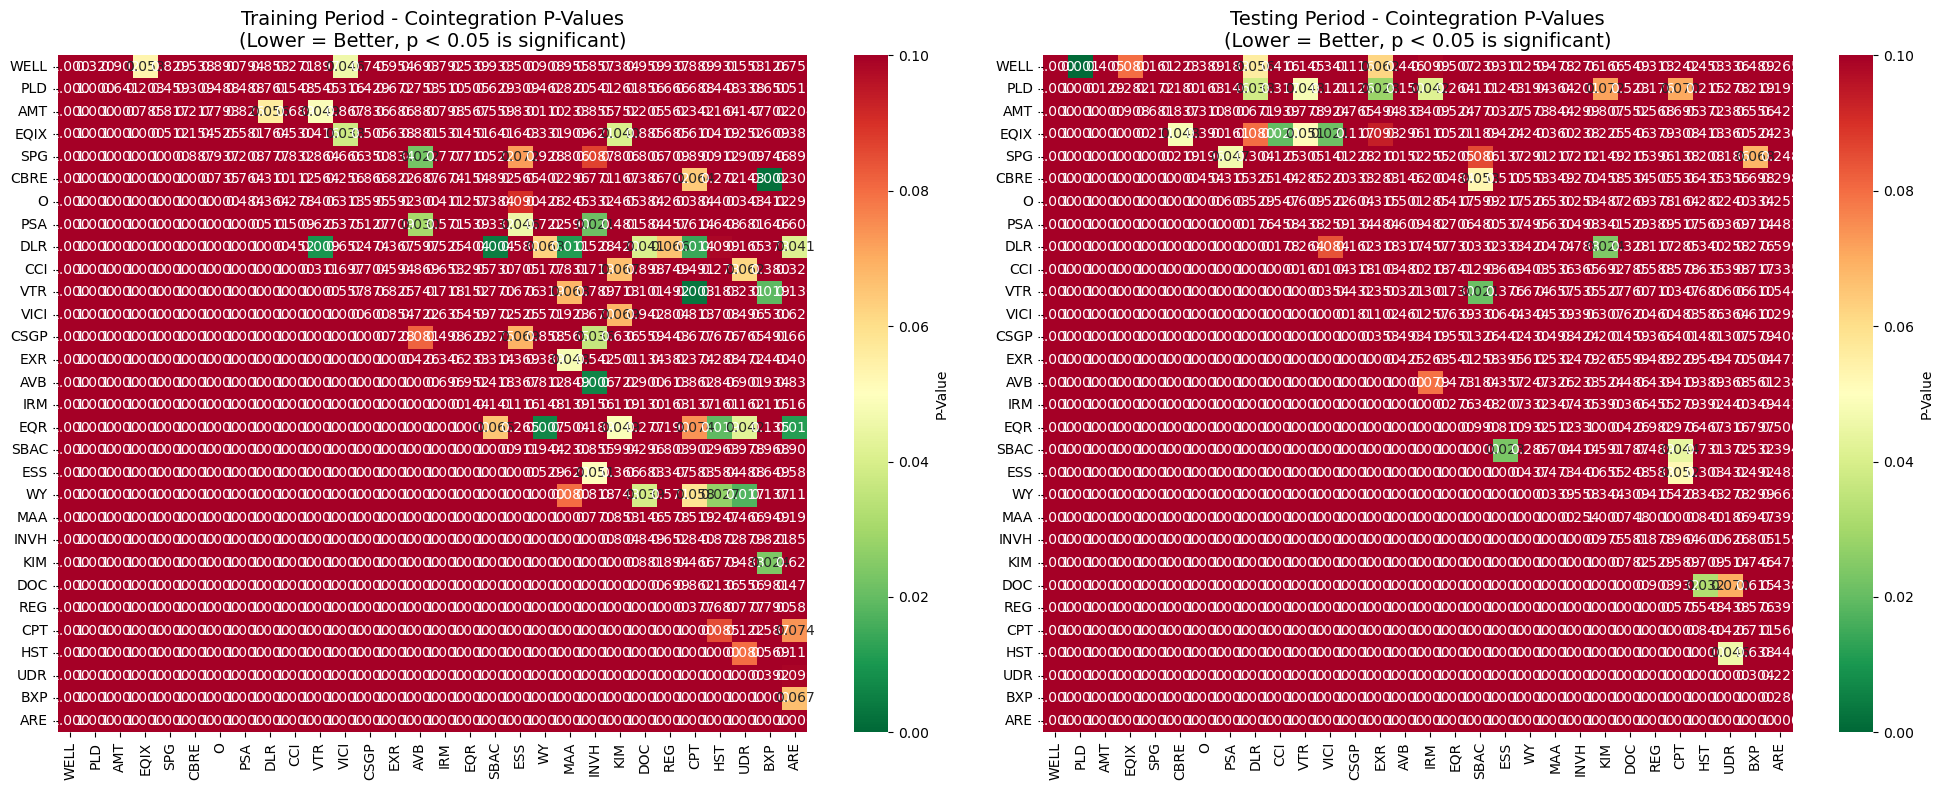

In [31]:
# Visualize cointegration results - Training vs Testing period
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Training period heatmap
sns.heatmap(
    pvalues_train, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r',  # Red = high p-value (bad), Green = low p-value (good)
    vmin=0, 
    vmax=0.1,  # Focus on the significant range
    ax=axes[0],
    annot=True,
    fmt='.3f',
    cbar_kws={'label': 'P-Value'}
)
axes[0].set_title('Training Period - Cointegration P-Values\n(Lower = Better, p < 0.05 is significant)', fontsize=14)

# Testing period heatmap
sns.heatmap(
    pvalues_test, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r',
    vmin=0, 
    vmax=0.1,
    ax=axes[1],
    annot=True,
    fmt='.3f',
    cbar_kws={'label': 'P-Value'}
)
axes[1].set_title('Testing Period - Cointegration P-Values\n(Lower = Better, p < 0.05 is significant)', fontsize=14)

plt.tight_layout()
plt.show()

In [32]:
# def print_best_pair_summary(best_pair, pvalues_train, pvalues_test, train_data, test_data):
#     """
#     Print a summary of the best pair selected for backtesting.
    
#     Parameters:
#     best_pair: tuple of (symbol1, symbol2)
#     pvalues_train: p-value matrix from training period
#     pvalues_test: p-value matrix from testing period
#     train_data: training DataFrame
#     test_data: testing DataFrame
#     """
#     symbol1, symbol2 = best_pair
    
#     # Get p-values for the pair
#     cols = list(train_data.columns)
#     i = cols.index(symbol1)
#     j = cols.index(symbol2)
    
#     # Ensure we access the upper triangular part (i < j)
#     if i > j:
#         i, j = j, i
    
#     train_pvalue = pvalues_train[i, j]
#     test_pvalue = pvalues_test[i, j]
    
#     # Determine consistency
#     is_consistent = train_pvalue < 0.1 and test_pvalue < 0.1
    
#     print("=" * 50)
#     print("BEST PAIR SUMMARY")
#     print("=" * 50)
#     print(f"Pair: {symbol1} / {symbol2}")
#     print("-" * 50)
#     print(f"Training P-Value:  {train_pvalue:.4f} {'✅' if train_pvalue < 0.05 else '⚠️' if train_pvalue < 0.1 else '❌'}")
#     print(f"Testing P-Value:   {test_pvalue:.4f} {'✅' if test_pvalue < 0.05 else '⚠️' if test_pvalue < 0.1 else '❌'}")
#     print("-" * 50)
#     print(f"Consistent: {'Yes ✅' if is_consistent else 'No ❌'}")
#     print("=" * 50)
    
#     return {
#         'pair': best_pair,
#         'train_pvalue': train_pvalue,
#         'test_pvalue': test_pvalue,
#         'consistent': is_consistent
#     }

# # Print the best pair summary
# if 'best_pair' in locals():
#     best_pair_info = print_best_pair_summary(
#         best_pair, 
#         pvalues_train_relaxed, 
#         pvalues_test_relaxed, 
#         train_data, 
#         test_data
#     )
# else:
#     print("No best_pair defined. Run the cointegration analysis first.")

In [33]:
# # Display training pairs and validation results
# print("=== TRAINING PERIOD COINTEGRATED PAIRS ===")
# if len(pairs_train) > 0:
#     pairs_train_df = pd.DataFrame(pairs_train, columns=['Symbol 1', 'Symbol 2'])
    
#     # Get the scores and p-values for the training pairs
#     pair_scores_train = []
#     pair_pvalues_train = []
    
#     for pair in pairs_train:
#         symbol1, symbol2 = pair
#         # Find the indices of the symbols in the training data columns
#         i = list(train_data.columns).index(symbol1)
#         j = list(train_data.columns).index(symbol2)
        
#         # Ensure upper triangular access (i < j)
#         if i > j:
#             i, j = j, i
        
#         pair_scores_train.append(scores_train[i, j])
#         pair_pvalues_train.append(pvalues_train[i, j])
    
#     pairs_train_df['Training Score'] = pair_scores_train
#     pairs_train_df['Training P-Value'] = pair_pvalues_train
#     pairs_train_df.sort_values(by='Training P-Value', inplace=True)
    
#     print(f"Found {len(pairs_train)} cointegrated pairs in training period:")
#     print(pairs_train_df)
# else:
#     print("No cointegrated pairs found in training period with p-value < 0.05")

# # ...existing code...

# print(f"\n=== VALIDATION RESULTS ===")
# print(f"Consistent pairs (cointegrated in both periods): {len(consistent_pairs)}")
# if len(consistent_pairs) > 0:
#     print("Best consistent pairs for backtesting:")
#     consistent_df = validation_df[validation_df['consistent']].head(3)
#     print(consistent_df[['pair', 'train_pvalue', 'test_pvalue']])
# else:
#     print("No pairs maintained cointegration in testing period")
#     print("This suggests overfitting or structural breaks in the relationships")

In [34]:
# Enhanced Backtesting Framework
# Use parameters estimated from training period and test on out-of-sample data
def estimate_hedge_ratio_and_spread(data, symbol1, symbol2):
    """
    Estimate hedge ratio and calculate spread for a pair
    Returns regression results and spread series
    """
    S1 = data[symbol1]
    S2 = data[symbol2]
    
    # Add constant for regression
    S1_const = sm.add_constant(S1)
    results = sm.OLS(S2, S1_const).fit()
    
    # Get regression coefficient (hedge ratio)
    hedge_ratio = results.params[symbol1]
    intercept = results.params['const']
    
    # Calculate spread
    spread = S2 - hedge_ratio * S1
    
    return {
        'hedge_ratio': hedge_ratio,
        'intercept': intercept,
        'results': results,
        'spread': spread,
        'spread_mean': spread.mean(),
        'spread_std': spread.std()
    }

def backtest_pair_strategy(train_data, test_data, symbol1, symbol2, z_threshold=1.0):
    """
    Backtest a pairs trading strategy:
    1. Estimate parameters on training data
    2. Apply strategy on test data with those parameters
    """
    print(f"\n=== BACKTESTING {symbol1}/{symbol2} ===")
    
    # Step 1: Estimate parameters on training data
    train_params = estimate_hedge_ratio_and_spread(train_data, symbol1, symbol2)
    
    print(f"Training Period Parameters:")
    print(f"  Hedge Ratio: {train_params['hedge_ratio']:.4f}")
    print(f"  R-squared: {train_params['results'].rsquared:.4f}")
    print(f"  Spread Mean: {train_params['spread_mean']:.4f}")
    print(f"  Spread Std: {train_params['spread_std']:.4f}")
    
    # Step 2: Apply strategy on test data using training parameters
    S1_test = test_data[symbol1]
    S2_test = test_data[symbol2]
    
    # Calculate spread using training hedge ratio
    spread_test = S2_test - train_params['hedge_ratio'] * S1_test
    
    # Calculate z-score using training mean and std
    zscore_test = (spread_test - train_params['spread_mean']) / train_params['spread_std']
    
    # Generate trading signals
    signals = pd.DataFrame(index=test_data.index)
    signals['spread'] = spread_test
    signals['zscore'] = zscore_test
    signals['position'] = 0.0
    
    # Long spread when z-score <= -threshold
    signals.loc[signals.zscore <= -z_threshold, 'position'] = 1.0
    # Short spread when z-score >= threshold  
    signals.loc[signals.zscore >= z_threshold, 'position'] = -1.0
    
    # Calculate returns
    signals['spread_returns'] = signals.spread.pct_change()
    signals['strategy_returns'] = signals.spread_returns * signals.position.shift(1)
    signals = signals.dropna()
    
    # Performance metrics
    total_return = signals.strategy_returns.cumsum().iloc[-1]
    sharpe_ratio = signals.strategy_returns.mean() / signals.strategy_returns.std() * np.sqrt(252) if signals.strategy_returns.std() != 0 else 0
    win_rate = (signals[signals.strategy_returns > 0].shape[0] / 
               signals[signals.strategy_returns != 0].shape[0]) if signals[signals.strategy_returns != 0].shape[0] > 0 else 0
    
    print(f"\nOut-of-Sample Test Results:")
    print(f"  Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
    print(f"  Annualized Sharpe: {sharpe_ratio:.4f}")
    print(f"  Win Rate: {win_rate:.2%}")
    print(f"  Number of Trades: {(signals.position != 0).sum()}")
    
    return {
        'signals': signals,
        'train_params': train_params,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate
    }

# Run backtest on the available pair
if len(consistent_pairs) > 0:
    best_pair = consistent_pairs[0]
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
elif len(pairs_train) > 0:
    best_pair = pairs_train[0]
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
    
    print(f"\n WARNING: This pair was not consistently cointegrated across periods")
    print("This is a demonstration of the methodology, not a robust trading signal")
else:
    print("No pairs available for backtesting")
    print("Consider adjusting the cointegration threshold or using different data")


=== BACKTESTING EQR/UDR ===
Training Period Parameters:
  Hedge Ratio: 0.6528
  R-squared: 0.9483
  Spread Mean: -1.4703
  Spread Std: 1.4487

Out-of-Sample Test Results:
  Total Return: 0.0490 (4.90%)
  Annualized Sharpe: 0.0309
  Win Rate: 47.19%
  Number of Trades: 409


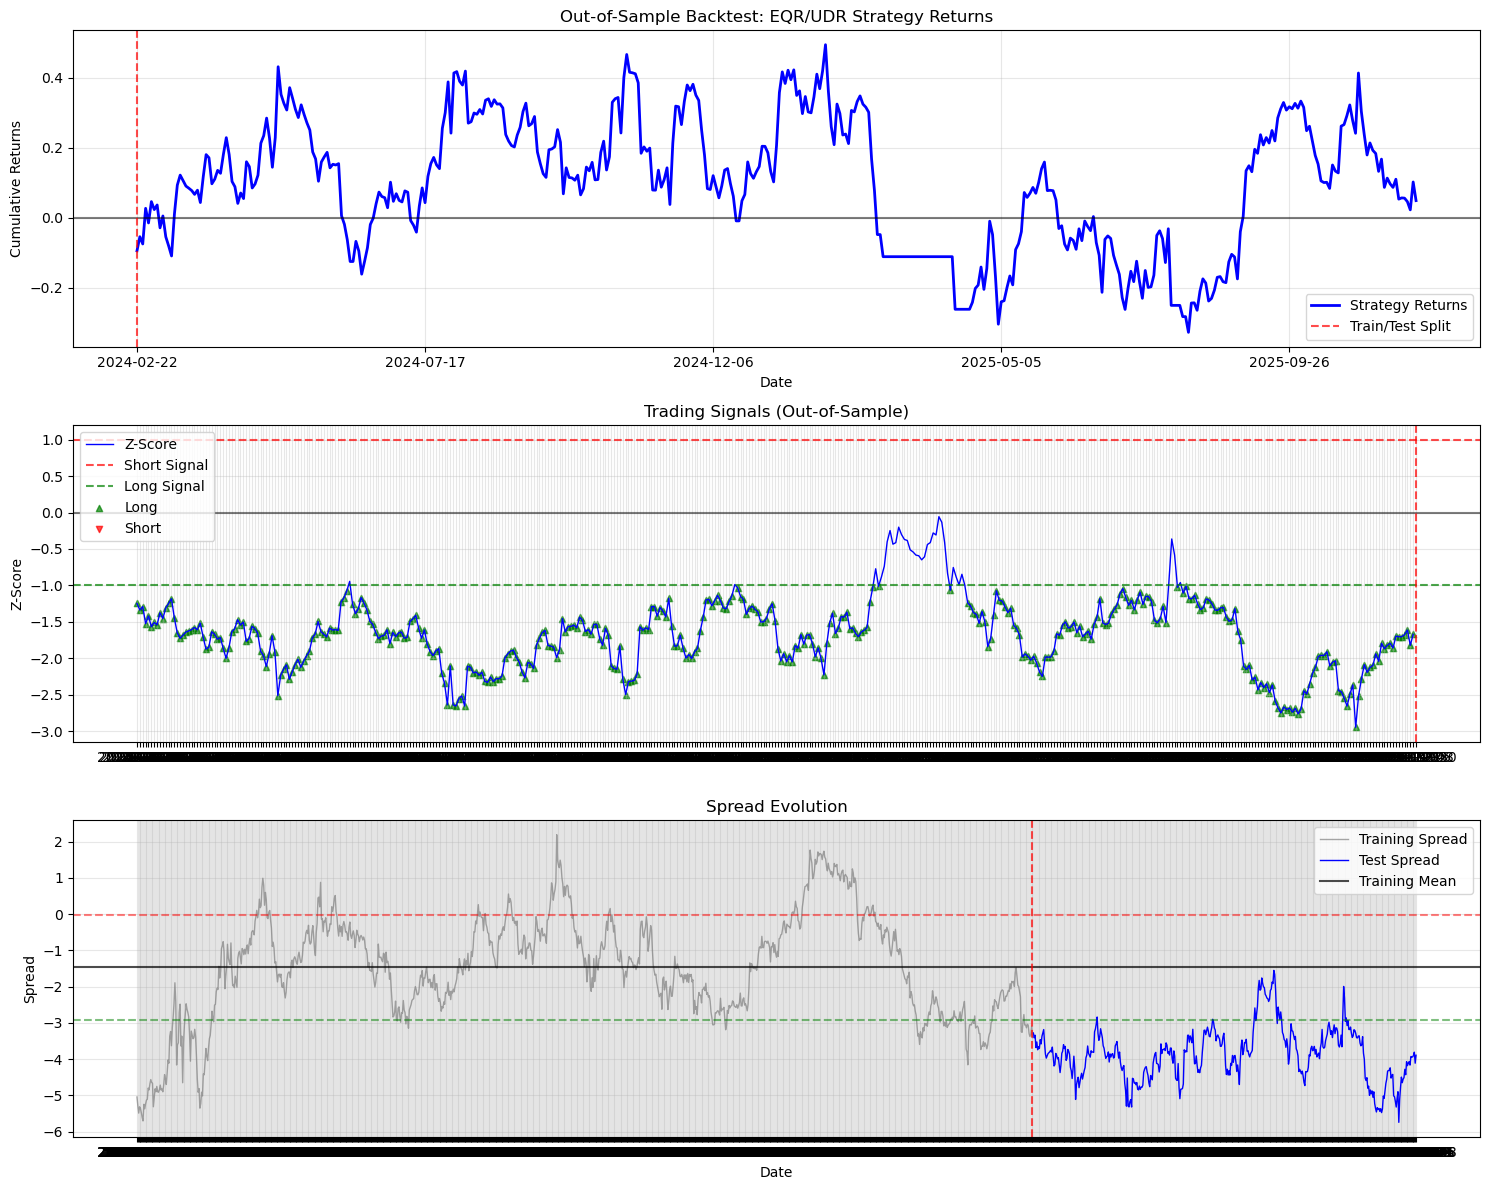


=== BACKTEST PERFORMANCE SUMMARY ===
           Metric   Value
     Total Return   4.90%
Annualized Sharpe   0.031
         Win Rate   47.2%
 Number of Trades     409
      Training R²   0.948
     Max Drawdown -82.23%


In [35]:
# Visualize backtest results
if len(consistent_pairs) > 0 and 'backtest_results' in locals():
    
    signals = backtest_results['signals']
    train_params = backtest_results['train_params']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Cumulative returns comparison
    cumulative_returns = signals.strategy_returns.cumsum()
    cumulative_returns.plot(ax=axes[0], title=f'Out-of-Sample Backtest: {best_pair[0]}/{best_pair[1]} Strategy Returns', 
                           linewidth=2, color='blue', label='Strategy Returns')
    axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0].axvline(split_date, color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
    axes[0].set_ylabel('Cumulative Returns')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Z-score and signals
    axes[1].plot(signals.index, signals.zscore, linewidth=1, color='blue', label='Z-Score')
    axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
    axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
    axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1].axvline(split_date, color='red', linestyle='--', alpha=0.7)
    
    # Mark trades
    long_trades = signals[signals.position == 1]
    short_trades = signals[signals.position == -1]
    axes[1].scatter(long_trades.index, long_trades.zscore, color='green', marker='^', s=20, alpha=0.7, label='Long')
    axes[1].scatter(short_trades.index, short_trades.zscore, color='red', marker='v', s=20, alpha=0.7, label='Short')
    
    axes[1].set_title('Trading Signals (Out-of-Sample)')
    axes[1].set_ylabel('Z-Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Spread evolution
    axes[2].plot(train_params['spread'].index, train_params['spread'], 
                linewidth=1, color='gray', alpha=0.7, label='Training Spread')
    axes[2].plot(signals.index, signals.spread, linewidth=1, color='blue', label='Test Spread')
    axes[2].axhline(train_params['spread_mean'], color='black', linestyle='-', alpha=0.7, label='Training Mean')
    axes[2].axhline(train_params['spread_mean'] + train_params['spread_std'], color='red', linestyle='--', alpha=0.5)
    axes[2].axhline(train_params['spread_mean'] - train_params['spread_std'], color='green', linestyle='--', alpha=0.5)
    axes[2].axvline(split_date, color='red', linestyle='--', alpha=0.7)
    
    axes[2].set_title('Spread Evolution')
    axes[2].set_ylabel('Spread')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    summary_stats = pd.DataFrame({
        'Metric': ['Total Return', 'Annualized Sharpe', 'Win Rate', 'Number of Trades', 
                  'Training R²', 'Max Drawdown'],
        'Value': [f"{backtest_results['total_return']:.2%}", 
                 f"{backtest_results['sharpe_ratio']:.3f}",
                 f"{backtest_results['win_rate']:.1%}",
                 f"{(signals.position != 0).sum()}",
                 f"{train_params['results'].rsquared:.3f}",
                 f"{(cumulative_returns - cumulative_returns.expanding().max()).min():.2%}"]
    })
    
    print("\n=== BACKTEST PERFORMANCE SUMMARY ===")
    print(summary_stats.to_string(index=False))

In [36]:
# Pairs Trading Analysis
# Selected Pair Analysis
# Setup regression and calculate spread

# Use the best pair from cointegration analysis
if len(consistent_pairs) > 0:
    best_pair = consistent_pairs[0]  # Use first consistent pair
elif len(pairs_train) > 0:
    best_pair = pairs_train[0]  # Fallback to best training pair
    print("WARNING: No consistent pairs found. Using best training pair for demonstration.")
else:
    raise ValueError("No cointegrated pairs found. Cannot proceed with analysis.")

symbol1, symbol2 = best_pair
print(f"Analyzing pair: {symbol1}/{symbol2}")

S1 = data[symbol1]  # Independent variable
S2 = data[symbol2]  # Dependent variable

# Add constant for regression
S1_const = sm.add_constant(S1)
results_pair1 = sm.OLS(S2, S1_const).fit()

# Get regression coefficient (hedge ratio)
b_pair1 = results_pair1.params[symbol1]
intercept_pair1 = results_pair1.params['const']

# Calculate spread
spread_pair1 = S2 - b_pair1 * S1

print(f"\n{symbol1}/{symbol2} Regression Results:")
print(f"Hedge Ratio (beta): {b_pair1:.4f}")
print(f"Intercept: {intercept_pair1:.4f}")
print(f"R-squared: {results_pair1.rsquared:.4f}")
print(f"Spread mean: {spread_pair1.mean():.4f}")
print(f"Spread std: {spread_pair1.std():.4f}")
print("\nRegression Summary:")
print(results_pair1.summary())

Analyzing pair: EQR/UDR

EQR/UDR Regression Results:
Hedge Ratio (beta): 0.6132
Intercept: 0.2506
R-squared: 0.9145
Spread mean: 0.2506
Spread std: 1.6440

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    UDR   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 1.587e+04
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:36:51   Log-Likelihood:                -2846.8
No. Observations:                1486   AIC:                             5698.
Df Residuals:                    1484   BIC:                             5708.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err  

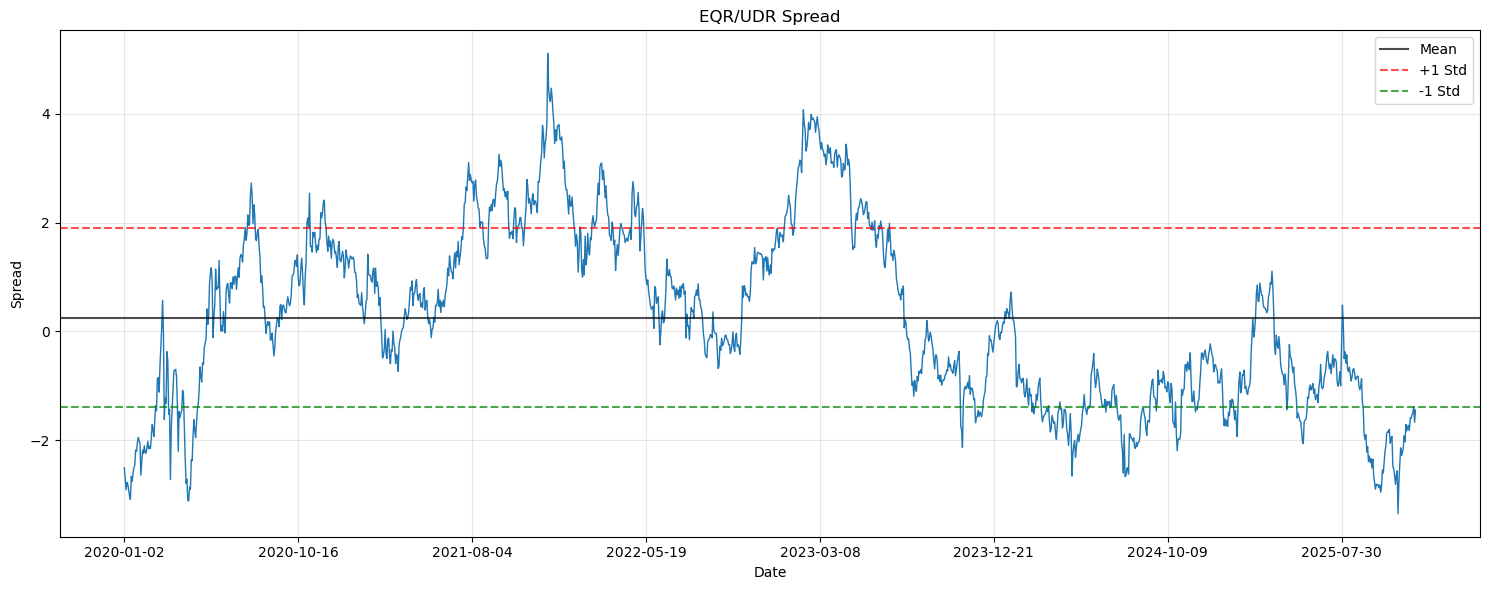

In [37]:
# Plot spread for selected pair
plt.figure(figsize=(15, 6))
spread_pair1.plot(title=f'{symbol1}/{symbol2} Spread', linewidth=1)
plt.axhline(spread_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(spread_pair1.mean() + spread_pair1.std(), color='red', linestyle='--', alpha=0.7, label='+1 Std')
plt.axhline(spread_pair1.mean() - spread_pair1.std(), color='green', linestyle='--', alpha=0.7, label='-1 Std')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

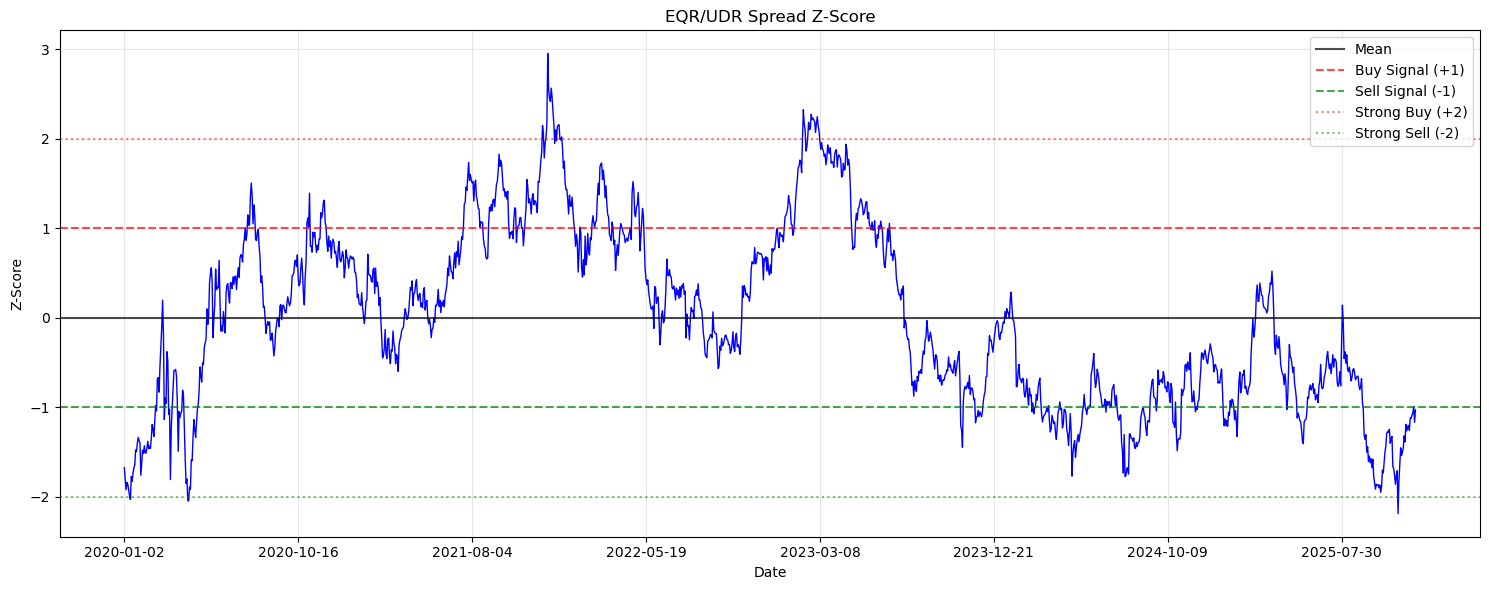

Z-score statistics for EQR/UDR:
Mean: 0.0000
Std: 1.0003
Min: -2.1923
Max: 2.9564


In [38]:
# Z-score calculation and visualization for selected pair
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Calculate z-score of spread
zscore_pair1 = zscore(spread_pair1)

# Plot z-score
plt.figure(figsize=(15, 6))
zscore_pair1.plot(title=f'{symbol1}/{symbol2} Spread Z-Score', linewidth=1, color='blue')
plt.axhline(zscore_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Buy Signal (+1)')
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Sell Signal (-1)')
plt.axhline(2.0, color='red', linestyle=':', alpha=0.5, label='Strong Buy (+2)')
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5, label='Strong Sell (-2)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Z-score statistics for {symbol1}/{symbol2}:")
print(f"Mean: {zscore_pair1.mean():.4f}")
print(f"Std: {zscore_pair1.std():.4f}")
print(f"Min: {zscore_pair1.min():.4f}")
print(f"Max: {zscore_pair1.max():.4f}")

In [39]:
# Trading Strategy for selected pair
# Create DataFrame with signal and position
trades_pair1 = pd.DataFrame({
    'signal': zscore_pair1,
    'position': spread_pair1,
    symbol1: S1,
    symbol2: S2
})

# Add trading side based on z-score thresholds
trades_pair1['side'] = 0.0
trades_pair1.loc[trades_pair1.signal <= -1, 'side'] = 1.0   # Long spread when z-score <= -1
trades_pair1.loc[trades_pair1.signal >= 1, 'side'] = -1.0   # Short spread when z-score >= 1

# Calculate position changes and returns
trades_pair1['position_change'] = trades_pair1.position.pct_change()
trades_pair1['strategy_returns'] = trades_pair1.position_change * trades_pair1.side.shift(1)

# Remove NaN values
trades_pair1 = trades_pair1.dropna()

print(f"{symbol1}/{symbol2} Trading Signals Summary:")
print(f"Total trading signals: {(trades_pair1.side != 0).sum()}")
print(f"Long signals: {(trades_pair1.side == 1).sum()}")
print(f"Short signals: {(trades_pair1.side == -1).sum()}")
print(f"Signal ratio: {(trades_pair1.side != 0).mean():.2%}")

# Display first few trades
print("\nFirst 10 trading signals:")
signal_trades = trades_pair1[trades_pair1.side != 0].head(10)
print(signal_trades[['signal', 'side', 'strategy_returns']])

EQR/UDR Trading Signals Summary:
Total trading signals: 540
Long signals: 267
Short signals: 273
Signal ratio: 36.36%

First 10 trading signals:
              signal  side  strategy_returns
Date                                        
2020-01-03 -1.807758   1.0          0.084477
2020-01-06 -1.925018   1.0          0.070841
2020-01-07 -1.842100   1.0         -0.046780
2020-01-08 -1.863888   1.0          0.012895
2020-01-09 -1.926532   1.0          0.036604
2020-01-10 -1.990511   1.0          0.036065
2020-01-13 -2.032139   1.0          0.022648
2020-01-14 -1.775129   1.0         -0.136733
2020-01-15 -1.832661   1.0          0.035456
2020-01-16 -1.739803   1.0         -0.055267


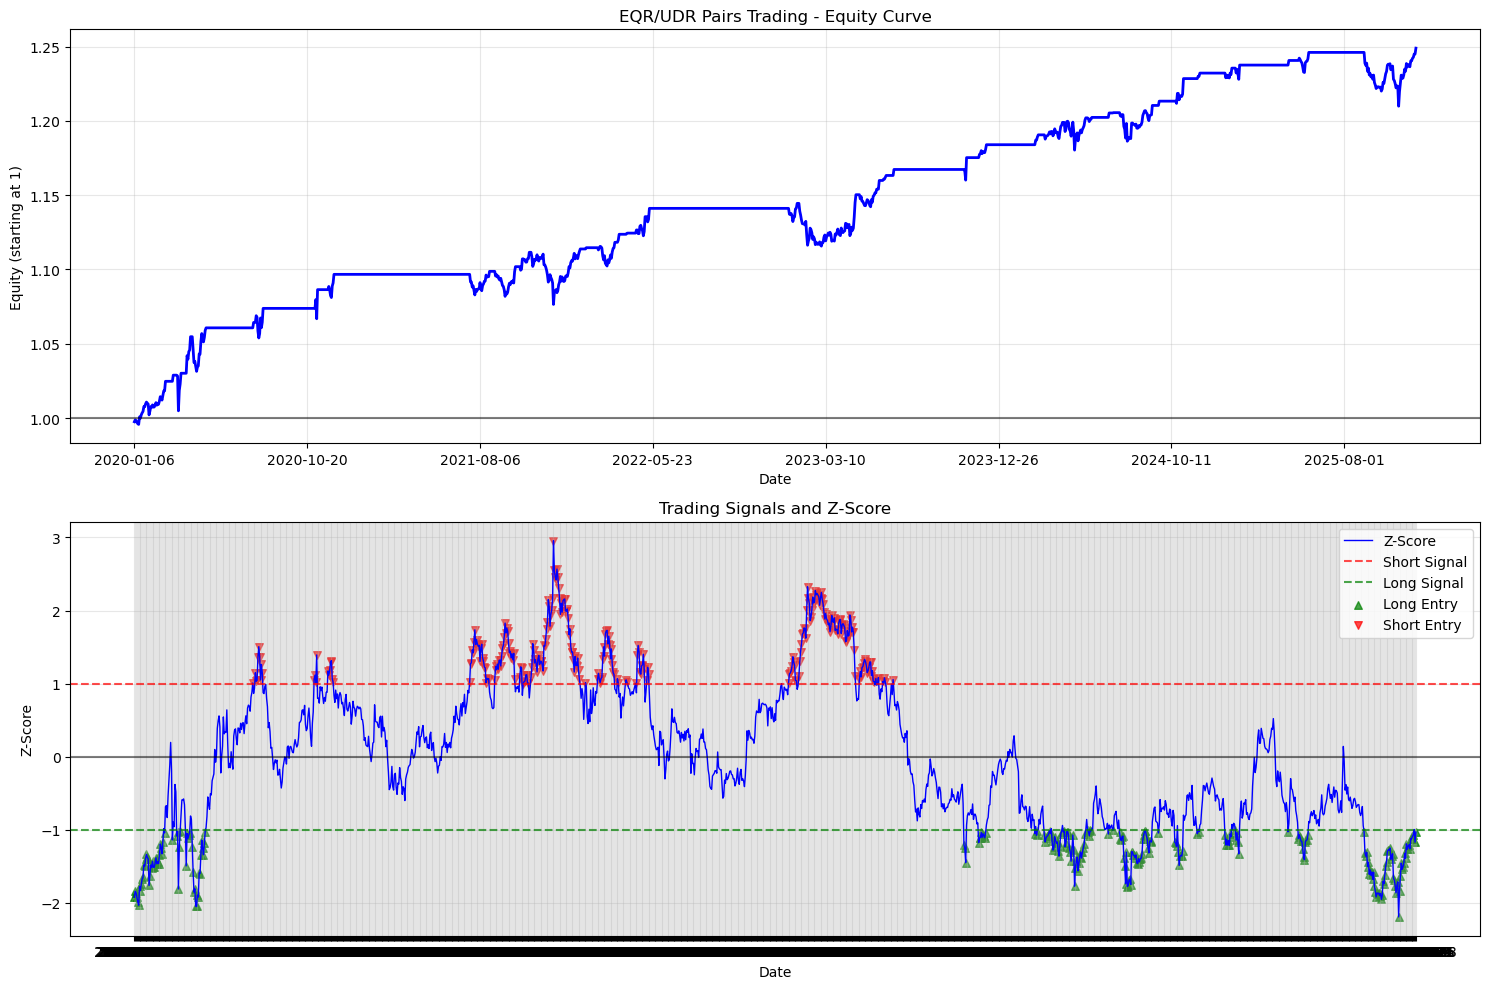


EQR/UDR Strategy Performance:
Total Return: 0.2489 (24.89%)
Annualized Sharpe Ratio: 1.1594
Maximum Drawdown: -0.0316 (-3.16%)


In [40]:
# Plot strategy performance for selected pair
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Calculate returns properly for pairs trading
# For a pairs trade: Long symbol2, Short symbol1 (when spread is expected to rise)
# Returns = weight2 * return2 - weight1 * return1
# Using equal dollar weights for simplicity

# Calculate individual stock returns
returns_S1 = S1.pct_change()
returns_S2 = S2.pct_change()

# Align with trades_pair1 index
returns_S1 = returns_S1.reindex(trades_pair1.index)
returns_S2 = returns_S2.reindex(trades_pair1.index)

# Strategy returns: when side=1 (long spread), we're long S2, short S1
# when side=-1 (short spread), we're short S2, long S1
# Use equal weights (0.5 each side)
trades_pair1['strategy_returns'] = trades_pair1.side.shift(1) * 0.5 * (returns_S2 - returns_S1)
trades_pair1 = trades_pair1.dropna()

# Plot cumulative returns using equity curve
equity_curve = (1 + trades_pair1.strategy_returns).cumprod()
equity_curve.plot(ax=axes[0], title=f'{symbol1}/{symbol2} Pairs Trading - Equity Curve', 
                  linewidth=2, color='blue')
axes[0].axhline(1, color='black', linestyle='-', alpha=0.5)
axes[0].set_ylabel('Equity (starting at 1)')
axes[0].grid(True, alpha=0.3)

# Plot signals with z-score
axes[1].plot(trades_pair1.index, trades_pair1.signal, linewidth=1, color='blue', label='Z-Score')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Mark actual trades
long_trades = trades_pair1[trades_pair1.side == 1]
short_trades = trades_pair1[trades_pair1.side == -1]
axes[1].scatter(long_trades.index, long_trades.signal, color='green', marker='^', s=30, alpha=0.7, label='Long Entry')
axes[1].scatter(short_trades.index, short_trades.signal, color='red', marker='v', s=30, alpha=0.7, label='Short Entry')

axes[1].set_title('Trading Signals and Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics (CORRECTED)
# Total return (compounded)
total_return = equity_curve.iloc[-1] - 1

# Sharpe ratio
sharpe_ratio = trades_pair1.strategy_returns.mean() / trades_pair1.strategy_returns.std() * np.sqrt(252)

# Max drawdown (from equity curve)
rolling_max = equity_curve.expanding().max()
drawdown = (equity_curve - rolling_max) / rolling_max
max_drawdown = drawdown.min()

print(f"\n{symbol1}/{symbol2} Strategy Performance:")
print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")